In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use("seaborn-paper")

In [69]:
# select patient and control group size 
# This patient has a known expression outlier in DNAJC3
patient = '61695'
sample_size= 50

In [70]:
def open_ct_file(filepath,sep='\t', skiprows=0):
    return pd.read_csv(filepath, sep=sep, encoding='utf8', skiprows=skiprows)

counts_df = open_ct_file("DATA/41467_2017_BFncomms15824_MOESM390_ESM.txt")


In [71]:
#transpose
counts_df = counts_df.T

counts_df

,DDX11L1,OR4F5,M37726,LOC643837,AK056486,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,...,STRF6,DQ584698,MTND5,cytochrome b,AF079515,DQ582201,JA760602,JA760600,JA760615,tRNA Pro
65937,10,0,0,626,5,317,80,7,45,557,...,0,0,0,0,706,18,37448,0,0,0
66623,17,0,0,525,7,126,106,34,128,1880,...,0,0,0,0,842,20,23645,0,0,0
69245,0,0,0,1268,44,1302,307,57,93,1363,...,0,0,0,0,1085,63,35142,0,0,0
69248,15,0,0,539,14,61,255,16,503,3554,...,0,0,0,0,2271,23,53165,0,0,0
69456,7,0,0,726,54,1163,175,41,87,862,...,0,0,0,0,2540,63,43857,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MUC1410,12,0,0,665,10,139,264,19,392,4768,...,0,0,0,0,1611,98,30178,0,0,0
MUC1411,4,0,0,568,18,125,337,30,568,3374,...,0,0,0,0,915,266,23605,0,0,0
MUC1384,4,0,0,476,11,42,111,7,258,2491,...,0,0,0,0,471,155,9280,0,0,0
MUC1412,2,0,0,596,35,685,237,15,271,1878,...,0,0,0,0,683,91,26418,0,0,0


In [72]:
def counts_to_cpm(counts):
    #samples in row, features in columns
    total_counts = np.array([counts.iloc[x,:].sum()/1e6 for x in range(counts.shape[0])])
    return (counts.T / total_counts).apply(np.ceil).T


counts_df = counts_to_cpm(counts_df)



In [73]:
# drop levels with no gene expression counts
counts_df = counts_df.loc[:, (counts_df != 0).any(axis=0)]

# Clean the insufficient covered genes from the data mean expression > 15

counts_df = counts_df.loc[:, (counts_df.median() > 4 )] 

In [74]:
def plot_gene_expression_distribution(data):
    data_log2 = counts_df.apply(lambda x: np.log2(x + 1))
    mean_expression_per_gene = data_log2.mean(axis=0)
    plt.hist(x=mean_expression_per_gene, color='grey', bins=100, log=True)
    plt.axvline(x=mean_expression_per_gene.mean(), color='red', ls='--')
    plt.title("Distribution gene expression GTEx blood samples")
    plt.xlabel("Counts (log2)")
    plt.ylabel("Amount of genes")
    plt.show()



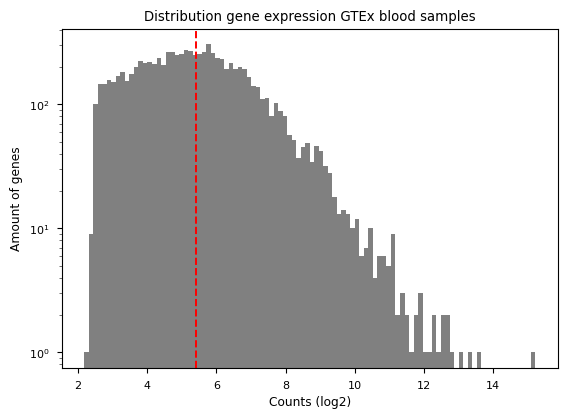

In [75]:
plot_gene_expression_distribution(counts_df)

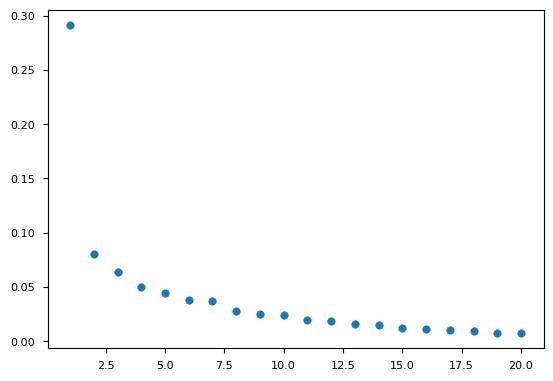

In [76]:
pca = PCA()

df_log2 = counts_df.apply(lambda x: np.log2(x + 1))
pca.fit(df_log2)

plt.scatter(x=np.arange(1,21), y=pca.explained_variance_ratio_[:20])

In [77]:
from sklearn.metrics import pairwise_distances

PC1_2 = pca.transform(df_log2)[:,:2]

index_pat = [c for c, s in enumerate(counts_df.index) if s == patient]

# Compute pairwise Euclidean distances between samples
distances = pairwise_distances(PC1_2, metric='euclidean')

index_distance_dict = {c:d for c, d in enumerate(distances[index_pat].flatten())}

sorted_closest_pc_indexes = [k for  k, v in sorted(index_distance_dict.items(), key=lambda x:x[1])]

[38]


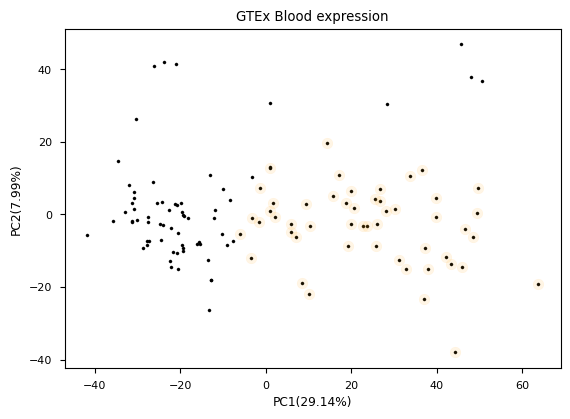

In [79]:
# plot with ischemic time. Keep only samples with 0 

import matplotlib.patches as mpatches
plt.scatter(x=PC1_2[:,0], y=PC1_2[:,1], s=5, c='black')
plt.scatter(x=PC1_2[sorted_closest_pc_indexes[:sample_size+1],0], y=PC1_2[sorted_closest_pc_indexes[:sample_size+1],1], s=60, c='orange', alpha=0.10)
plt.title("GTEx Blood expression")
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.02f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.02f}%)")
plt.show()


In [80]:
df_log2 = df_log2.iloc[sorted_closest_pc_indexes[:sample_size+1]]
df = counts_df.iloc[sorted_closest_pc_indexes[:sample_size+1]]

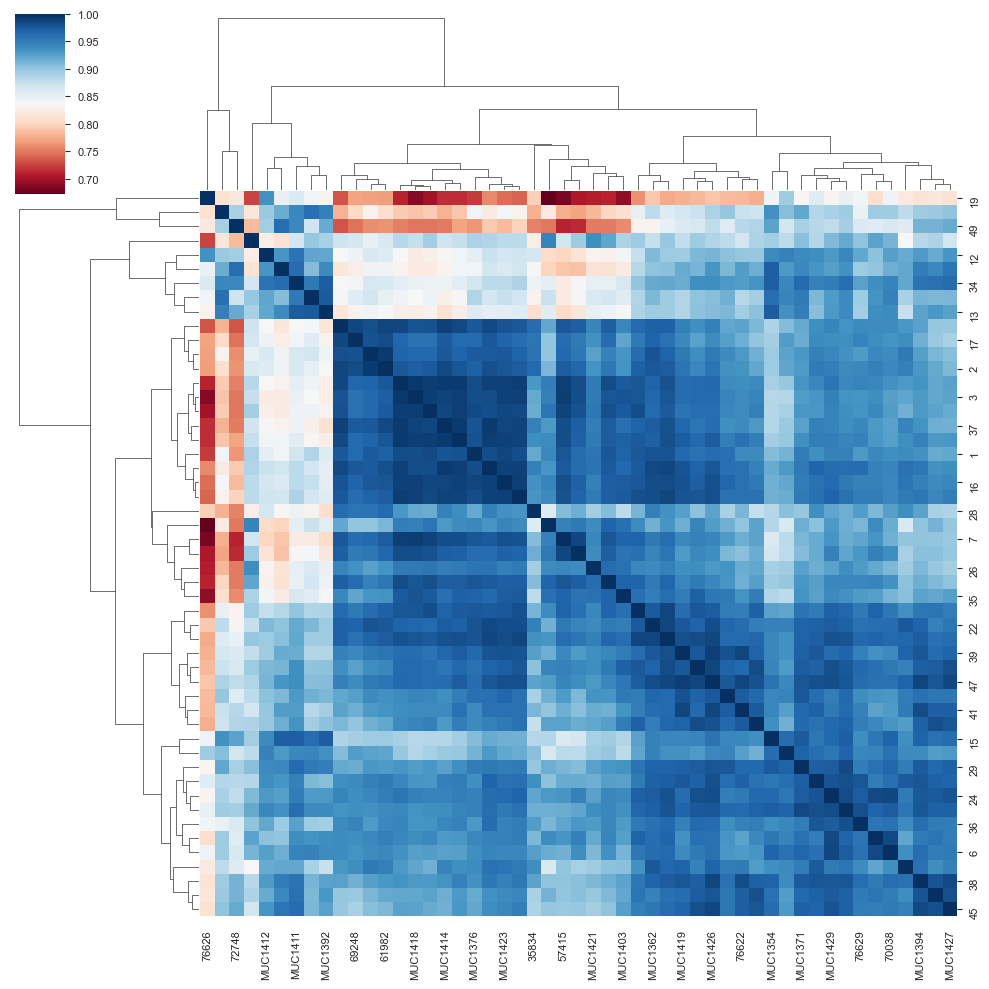

In [81]:
import seaborn as sns

corr = pd.DataFrame(np.corrcoef(df.T.values, rowvar=False), columns=df.T.columns)
sns.set_style("whitegrid")
sns.clustermap(corr, cmap='RdBu', method="complete")

In [82]:
# calculate zscores based on log2 counts
z_score_df = (df_log2 - df_log2.mean())/df_log2.std(ddof=0)

/var/folders/rj/lbtpvbdj0yxdj_ttcp98v_3w0000gn/T/ipykernel_1335/1766324924.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data, kde=False, norm_hist=True, bins=100)


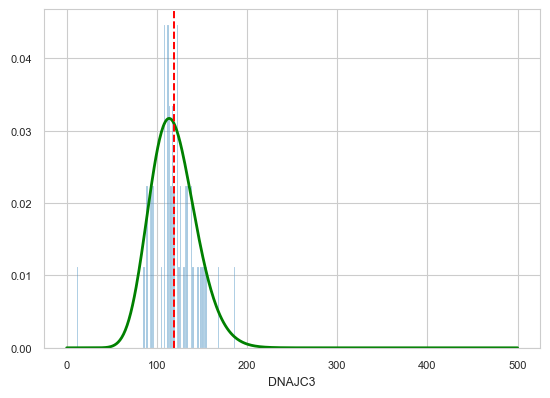

In [84]:
import statsmodels.api as sm
import scipy.stats as ss 
import seaborn as sns

# Use NB dist normally and fall back to Poisson dist if variance < mu

def get_nb_or_pois_val(s):
    mu = np.mean(s)
    sigma_sqr = np.var(s)
    if sigma_sqr >= mu:
        n = mu**2 / (sigma_sqr - mu)
        p = mu / sigma_sqr
        return "NB", mu, p, n
    else:
        # Poisson: If variance is not greater than mean, fall back to Poisson
        lambda_poisson = mu  # For Poisson, lambda = mu
        return "P", lambda_poisson

def two_tailed(pmf_values):
    return 2 * np.minimum(pmf_values, 1 - pmf_values)

def get_nb_or_pois_pvals(s):
    res = get_nb_or_pois_val(s)
    if res[0] == "NB":
        type_dist, mu, p, n = res
        pmf_values = ss.nbinom.pmf(s,n,p)
        return two_tailed(pmf_values)  # Two-tailed p-values
    else:
        type_dist, lambda_poisson = res
        pmf_values = ss.poisson.pmf(s,lambda_poisson)
        return two_tailed(pmf_values)  # Two-tailed p-values


data = df.iloc[:,:]["DNAJC3"]
x_plot = np.linspace(0,500,501)
res = get_nb_or_pois_val(data)

if res[0] == "NB":
    type_dist, mu, p, n = res
    pmf_values = ss.nbinom.pmf(x_plot,n,p)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values
else:
    type_dist, lambda_poisson = res
    pmf_values = ss.poisson.pmf(x_plot,lambda_poisson)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values

ax = sns.distplot(data, kde=False, norm_hist=True, bins=100)
ax.plot(x_plot, y_vals, 'g-', lw=2)
ax.axvline(x=mu, color='red', ls='--')
plt.show()

In [86]:

from statsmodels.stats.multitest import multipletests

# Fit data to NB and get probabilities

p_value_df = df.apply(func=lambda x: get_nb_or_pois_pvals((x)))


# Flatten the p-values into a single array
pvals = p_value_df.values.flatten()

# Apply FDR correction using B-Y procedure
# The result from multipletests is a tuple; we need the corrected p-values (last element of the tuple)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_by')

# Reshape the corrected p-values back into the original shape of the DataFrame
p_adj_df = pd.DataFrame(pvals_corrected.reshape(df.shape), columns=df.columns, index=df.index)

In [87]:
# create patient/effect dataframe

df_list = []
for patient_index in df.index:
    pat_df = pd.DataFrame({"patient":[patient_index for x in range(len(df.T.index))], "gene":df.T.index, "padj":p_adj_df.T[patient_index], "pValue":p_value_df.T[patient_index].values, "zScore":z_score_df.T[patient_index].values, "counts(CPM)":df.T[patient_index], "meanCounts(CPM)":df.mean().T}).reset_index()
    df_list.append(pat_df)

patients_df = pd.concat(df_list)
    

In [88]:
significant_df = patients_df[patients_df["padj"] < 0.05]

significant_df[(significant_df["patient"] == patient) & (significant_df["padj"] < 0.05)].sort_values("padj")

,index,patient,gene,padj,pValue,zScore,counts(CPM),meanCounts(CPM)
6177,DNAJC3,61695,DNAJC3,0.000015,4.889474e-12,-6.286532,11.0,118.647059


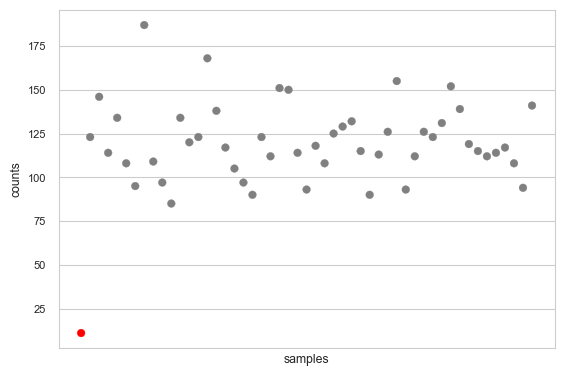

In [89]:
colors = ['red' if x == patient else 'grey' for x in df.index]
plt.scatter(df.index, df["DNAJC3"].values, c=colors)
plt.xlabel("samples")
plt.xticks([])
plt.ylabel("counts")
plt.show()

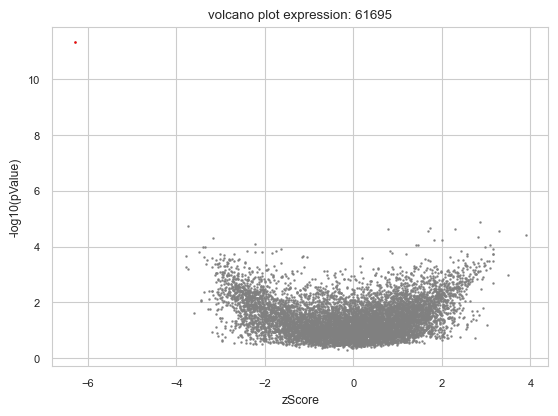

In [90]:
def negative_log10(x):
    return -np.log10(x)

plt.scatter(patients_df["zScore"][patients_df["patient"] == patient],negative_log10(patients_df["pValue"][patients_df["patient"] == patient]), s=2, color='grey')
plt.scatter(significant_df["zScore"][significant_df["patient"] == patient],negative_log10(significant_df["pValue"][significant_df["patient"] == patient]), s=2, color='red')

plt.xlabel("zScore")
plt.ylabel("-log10(pValue)")
plt.title(f'volcano plot expression: {patient}')

plt.show()